# Drug-target interaction prediction using direct & inderect correlation features

In [1]:
import pandas as pd
import numpy as np
import scipy
import itertools
from support_functions import log_progress

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=24)    # fontsize of the x and y labels   # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

In [2]:
# load the data
X_std_df = pd.DataFrame.from_csv('features/X_std.csv')
y_df = pd.DataFrame.from_csv('features/y.csv')
metadata_df = pd.DataFrame.from_csv('features/metadata.csv')

In [3]:
# format for sklearn
X_std = X_std_df.values
y = y_df.label.values

___
# Profile of the training set

- **strict reproducibility criteria** on which signatures are used
- **4 cell lines** with the most drug-target pairs tested
- **71 cpds** with known targets in CHEMBL or DrugBank
- **2520 potential targets** tested in the same cells
- **237 true interactions**


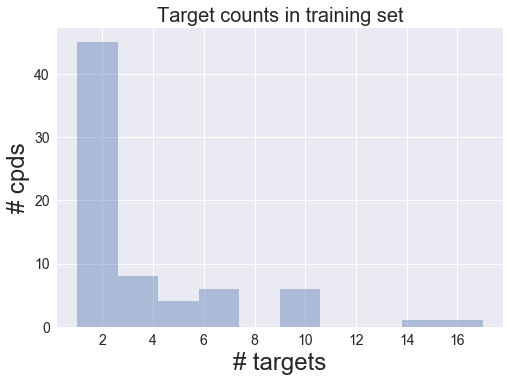

In [43]:
target_counts = metadata_df[metadata_df.label == 1].cpd.value_counts()
sns.distplot(target_counts, kde=False)
plt.ylabel('# cpds')
plt.xlabel('# targets')
plt.title('Target counts in training set')
plt.show()

___
# Features

**16 features** for each cpd-target pair. For each cell line: 
1. **Direct correlation** between cpd and potential target
2. **Max indirect correlation** with known interaction partners
3. **Min indirect correlation** with known interaction partners
4. **Avg indirect correlation** with known interaction partners

___
## Logistic regression

In [5]:
from sklearn.linear_model import LogisticRegression
LogisticRegression?

In [6]:
lr = LogisticRegression(C=100.0, random_state=1, class_weight="balanced", 
                        tol=1e-7, solver='newton-cg', max_iter=1000)
lr.fit(X_std, y)

LogisticRegression(C=100.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
          solver='newton-cg', tol=1e-07, verbose=0, warm_start=False)

### Training accuracy

In [7]:
metadata_df['prediction'] = lr.predict(X_std)

false_interactions = metadata_df[metadata_df.label==-1]
false_accuracy = (false_interactions[false_interactions.prediction==-1].shape[0] /
                  false_interactions.shape[0])

true_interactions = metadata_df[metadata_df.label==1]
true_accuracy = (true_interactions[true_interactions.prediction==1].shape[0] /
                  true_interactions.shape[0])


print('Accuracy on False interactions: {:.2f}'.format(false_accuracy))
print('Accuracy on True interactions: {:.2f}'.format(true_accuracy))

Accuracy on False interactions: 0.69
Accuracy on True interactions: 0.70


In [8]:
# evaluate top-100 accuracy
metadata_df['prob'] = lr.predict_proba(X_std)[:,1]

In [9]:
unique_cpds = metadata_df.cpd.unique()
top_100_results = pd.DataFrame(index=unique_cpds, columns=['num_targets', 'num_targets_predicted', 'top_target_rank'])

for c in unique_cpds:
    cpd_pairs = metadata_df.query('cpd == "{}"'.format(c)).copy()
    sorted_cpd_pairs = cpd_pairs.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    true_interactions = sorted_cpd_pairs.query('label == 1')
    num_true_interactions = len(true_interactions)
    best_rank = true_interactions.prob.idxmax()
    
    predicted_interactions = sorted_cpd_pairs.query('prediction == 1')
    num_predicted_interactions = len(predicted_interactions)
    
    top_100_results.at[c, 'top_target_rank'] = best_rank
    top_100_results.at[c, 'num_targets'] = num_true_interactions
    top_100_results.at[c, 'num_targets_predicted'] = num_predicted_interactions

In [10]:
num_top_100 = len(top_100_results.query('top_target_rank < 101'))
percent_top_100 = num_top_100 / len(top_100_results)
print('Cpds with known target in top 100 predictions: {} ({:.2f})'.format(num_top_100, percent_top_100))

Cpds with known target in top 100 predictions: 30 (0.42)


So here, our very basic logistic regression achieves top-100 accuracy of 42% for 71 compounds using data from 4 different cell lines. In comparison, LR in our LINCS manuscipt achieves top-100 accuracy of 38% for 29 compounds using data from 7 different cell lines.

___
# Random forest classification

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [22]:
RF = RandomForestClassifier(max_depth=16, random_state=0, n_estimators=100)
RF.fit(X_std, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [13]:
# save the model which was trained on all the data
import pickle
filename = 'model/RF_4.sav'
pickle.dump(RF, open(filename, 'wb'))

### Training Accuracy

In [14]:
metadata_df = pd.DataFrame.from_csv('features/metadata.csv')
metadata_df['prediction'] = RF.predict(X_std)

false_interactions = metadata_df[metadata_df.label==-1]
false_accuracy = (false_interactions[false_interactions.prediction==-1].shape[0] /
                  false_interactions.shape[0])

true_interactions = metadata_df[metadata_df.label==1]
true_accuracy = (true_interactions[true_interactions.prediction==1].shape[0] /
                  true_interactions.shape[0])


print('Accuracy on False interactions: {:.6f}'.format(false_accuracy))
print('Accuracy on True interactions: {:.6f}'.format(true_accuracy))

Accuracy on False interactions: 1.000000
Accuracy on True interactions: 0.354430


In [15]:
# evaluate top-100 accuracy
metadata_df['prob'] = RF.predict_proba(X_std)[:,1]

In [16]:
unique_cpds = metadata_df.cpd.unique()
top_100_results = pd.DataFrame(index=unique_cpds, columns=['true_targets', 'true_targets_predicted', 
                                                           'total_targets_predicted',
                                                           'top_true_target_rank', 'top_true_target_prob'])

for c in unique_cpds:
    cpd_pairs = metadata_df.query('cpd == "{}"'.format(c)).copy()
    sorted_cpd_pairs = cpd_pairs.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    true_interactions = sorted_cpd_pairs.query('label == 1')
    num_true_interactions = len(true_interactions)
    num_true_interactions_predicted = len(true_interactions.query('prediction == 1'))
    best_rank = true_interactions.prob.idxmax()
    top_prob = true_interactions.iloc[0].prob
    
    predicted_interactions = sorted_cpd_pairs.query('prediction == 1')
    num_predicted_interactions = len(predicted_interactions)
    
    top_100_results.at[c, 'top_true_target_rank'] = best_rank
    top_100_results.at[c, 'true_targets'] = num_true_interactions
    top_100_results.at[c, 'total_targets_predicted'] = num_predicted_interactions
    top_100_results.at[c, 'top_true_target_prob'] = top_prob
    top_100_results.at[c, 'true_targets_predicted'] = num_true_interactions_predicted

In [17]:
num_top_100 = len(top_100_results.query('top_true_target_rank < 101'))
percent_top_100 = num_top_100 / len(top_100_results)
print('Cpds with known target in top 100 predictions: {} ({:.2f})'.format(num_top_100, percent_top_100))

Cpds with known target in top 100 predictions: 71 (1.00)


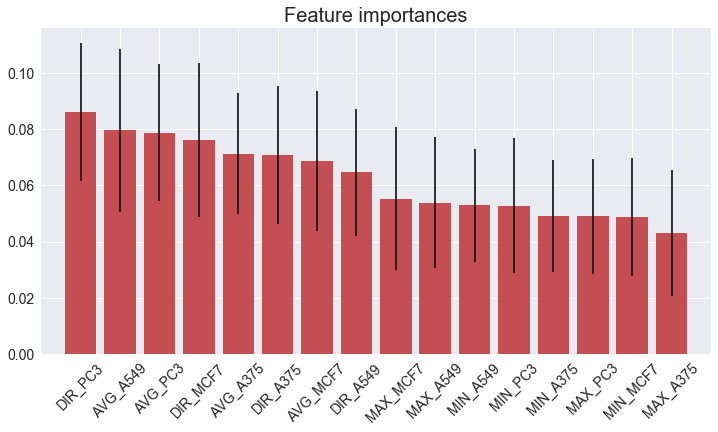

In [33]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0) # standard deviation of importances
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")
# for f in range(X_std.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

LABELS = np.array(["DIR_A375", "DIR_A549", "DIR_MCF7", "DIR_PC3",
          "MAX_A375", "MAX_A549", "MAX_MCF7", "MAX_PC3",
          "MIN_A375", "MIN_A549", "MIN_MCF7", "MIN_PC3",
          "AVG_A375", "AVG_A549", "AVG_MCF7", "AVG_PC3",
         ])[indices]

# Plot the feature importances of the forest
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(X_std.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
#plt.xticks(range(X_std.shape[1]), indices)
plt.xticks(range(X_std.shape[1]), LABELS, rotation=45)
plt.xlim([-1, X_std.shape[1]])
plt.show()

___
# Cross Validation - Random Forest

The training error is very low. Next we'll perform cross validation to get a sense of how well this generalizes.

In [34]:
# load data
X_std_df = pd.DataFrame.from_csv('features/X_std.csv')
y_df = pd.DataFrame.from_csv('features/y.csv')
metadata_df = pd.DataFrame.from_csv('features/metadata.csv')

# convert to np arrays
X_std = X_std_df.values
y = y_df.label.values

In [40]:
# 10-fold cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=20)

# store results
true_acc_ = []
false_acc_ = []
top_100_results_ = []


for train, test in log_progress(skf.split(X_std, y), every=1):
    X_train = X_std[train]
    y_train = y[train]
    X_test = X_std[test]
    y_test = y[test]
    test_metadata = metadata_df.iloc[test].copy()
    
    # train random forest, predict on test set
    RF = RandomForestClassifier(max_depth=16, random_state=1, n_estimators=100)
    RF.fit(X_train, y_train)
    test_metadata['prediction'] = RF.predict(X_test)
    test_metadata['prob'] = RF.predict_proba(X_test)[:,1]
    
    # test true/false accuracy
    false_interactions = test_metadata[test_metadata.label==-1]
    true_interactions = test_metadata[test_metadata.label==1]
    false_accuracy = (false_interactions[false_interactions.prediction==-1].shape[0] /
                      false_interactions.shape[0])
    true_accuracy = (true_interactions[true_interactions.prediction==1].shape[0] /
                      true_interactions.shape[0])
    false_acc_.append(false_accuracy)
    true_acc_.append(true_accuracy)

    # evaluate top-100 accuracy
    unique_cpds = test_metadata[test_metadata.label == 1].cpd.unique()
    top_100_results = pd.DataFrame(index=unique_cpds, columns=['true_targets', 'true_targets_predicted', 
                                                               'total_targets_predicted',
                                                               'top_true_target_rank', 'top_true_target_prob'])

    for c in unique_cpds:
        cpd_pairs = test_metadata.query('cpd == "{}"'.format(c)).copy()
        sorted_cpd_pairs = cpd_pairs.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

        true_interactions = sorted_cpd_pairs.query('label == 1')
        num_true_interactions = len(true_interactions)
        num_true_interactions_predicted = len(true_interactions.query('prediction == 1'))
        best_rank = true_interactions.prob.idxmax()
        top_prob = true_interactions.iloc[0].prob

        predicted_interactions = sorted_cpd_pairs.query('prediction == 1')
        num_predicted_interactions = len(predicted_interactions)

        top_100_results.at[c, 'top_true_target_rank'] = best_rank
        top_100_results.at[c, 'true_targets'] = num_true_interactions
        top_100_results.at[c, 'total_targets_predicted'] = num_predicted_interactions
        top_100_results.at[c, 'top_true_target_prob'] = top_prob
        top_100_results.at[c, 'true_targets_predicted'] = num_true_interactions_predicted
    
    top_100_results_.append(top_100_results)

In [41]:
print('Accuracy on True interactions: ', np.mean(true_acc_))
print('Accuracy on False interactions: ', np.mean(false_acc_))

Accuracy on True interactions:  0.0314393939394
Accuracy on False interactions:  1.0


In [42]:
top100 = []
top50 = []
top10 = []

for k, result in enumerate(top_100_results_):
    #print('Fold',k)
    
    num_top_100 = len(result.query('top_true_target_rank < 101'))
    percent_top_100 = num_top_100 / len(result)
    top100.append(percent_top_100)
    #print('Cpds with known target in top 100 predictions: {} ({:.4f})'.format(num_top_100, percent_top_100))
    
    num_top_50 = len(result.query('top_true_target_rank < 51'))
    percent_top_50 = num_top_50 / len(result)
    top50.append(percent_top_50)
    #print('Cpds with known target in top 50 predictions: {} ({:.4f})\n'.format(num_top_50, percent_top_50))
    
    num_top_10 = len(result.query('top_true_target_rank < 11'))
    percent_top_10 = num_top_10 / len(result)
    top10.append(percent_top_10)
    #print('Cpds with known target in top 50 predictions: {} ({:.4f})\n'.format(num_top_50, percent_top_50))
    
print('Percent top-100:  {:.2f}  +/-  {:.2f}'.format(np.mean(top100), np.std(top100)))
print('Percent top-50:  {:.2f}  +/-  {:.2f}'.format(np.mean(top50), np.std(top50)))
print('Percent top-10:  {:.2f}  +/-  {:.2f}'.format(np.mean(top10), np.std(top10)))

Percent top-100:  0.96  +/-  0.06
Percent top-50:  0.83  +/-  0.14
Percent top-10:  0.52  +/-  0.18
